In [4]:
import pandas as pd 
import numpy as np

from Feature_Engineering import feature_engineering
from preprocess_module import fraud_preprocessor
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn import over_sampling
from sklearn import ensemble
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, recall_score, f1_score
import sklearn.model_selection as ms
from businessscoring import businessgain
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Pre-Processing


In [5]:
features = feature_engineering(j_flag=0)

In [6]:
X = features.drop(['PotentialFraud', 'Service_Type','Provider'], axis=1)
y = features['PotentialFraud'] 

In [7]:
#create seperate dataset with dummy variables to add back after scaling
non_num = X[['Both_Service', 'Inpatient', 'Outpatient',\
            'isFraudConnected']]

#drop dummy variables
X = X.drop(['Both_Service', 'Inpatient', 'Outpatient',\
           'isFraudConnected'], axis =1)

In [8]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)

#add back dummy variables to scaled dataset 
X_scaled = pd.concat((X_scaled, non_num), axis=1)
X_scaled.head(5)

,Phys_Count,Patient_Count,Norm_Patient_Count,Claim_Count,Norm_Claim_Count,Inpatient_Count,Outpatient_Count,Norm_Inpatient_Count,Norm_Outpatient_Count,DuplicateClaims,...,ChronicCond_rheumatoidarthritis_1,ChronicCond_rheumatoidarthritis_2,ChronicCond_stroke_1,ChronicCond_stroke_2,NetworkDegree,NoPhysicianCount,Both_Service,Inpatient,Outpatient,isFraudConnected
0,0.470588,-0.017544,-0.155665,-0.086957,-0.184866,1.142857,-0.114286,1.833333,-1.833333,-0.081081,...,0.055556,-0.025641,0.500000,-0.057971,0.333333,0.0,1,0,0,0.0
1,2.235294,1.614035,0.031527,1.443478,0.030651,13.857143,0.714286,3.833333,-3.833333,1.783784,...,1.388889,1.743590,1.166667,1.661836,0.000000,0.0,1,0,0,1.0
2,1.882353,1.982456,0.222660,1.582609,0.143678,0.000000,1.790476,0.000000,0.000000,1.756757,...,1.888889,2.051282,2.333333,1.932367,0.666667,0.0,0,0,1,0.0
3,0.000000,8.245614,15.763547,13.034783,24.233716,0.000000,14.333333,0.000000,0.000000,9.945946,...,6.666667,9.000000,6.166667,8.386473,-0.333333,2.0,0,0,1,0.0
4,0.235294,0.578947,0.650246,0.530435,0.593870,0.857143,0.580952,0.500000,-0.500000,0.567568,...,0.500000,0.641026,1.166667,0.521739,1.333333,0.0,1,0,0,0.0


In [9]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

## K-Means Clustering

In [10]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)

KMeans(n_clusters=2)

In [11]:
km_class = pd.Series(kmeans.predict(X_scaled))
km_class.value_counts()

0    5271
1     139
dtype: int64

In [12]:
km_class = pd.DataFrame(kmeans.predict(X_scaled)).rename(columns={0:'KM_Class'})

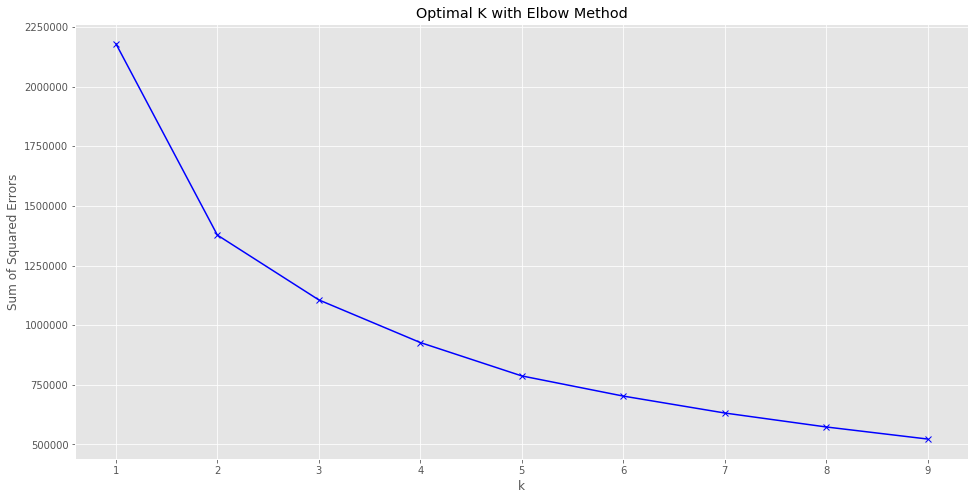

In [13]:
plt.style.use('ggplot')

## choosing K using Elbow Method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.figure(figsize=(16,8))
plt.plot(k_rng, sse, 'bx-')
plt.title('Optimal K with Elbow Method')
plt.xlabel('k')
plt.ylabel('Sum of Squared Errors')
plt.show()

### Random Forest with K-Means

In [14]:
full_KM = X_scaled.copy()
full_KM = pd.concat([full_KM, km_class], axis=1)

full_KM

,Phys_Count,Patient_Count,Norm_Patient_Count,Claim_Count,Norm_Claim_Count,Inpatient_Count,Outpatient_Count,Norm_Inpatient_Count,Norm_Outpatient_Count,DuplicateClaims,...,ChronicCond_rheumatoidarthritis_2,ChronicCond_stroke_1,ChronicCond_stroke_2,NetworkDegree,NoPhysicianCount,Both_Service,Inpatient,Outpatient,isFraudConnected,KM_Class
0,0.470588,-0.017544,-0.155665,-0.086957,-0.184866,1.142857,-0.114286,1.833333,-1.833333,-0.081081,...,-0.025641,0.500000,-0.057971,0.333333,0.0,1,0,0,0.0,0
1,2.235294,1.614035,0.031527,1.443478,0.030651,13.857143,0.714286,3.833333,-3.833333,1.783784,...,1.743590,1.166667,1.661836,0.000000,0.0,1,0,0,1.0,0
2,1.882353,1.982456,0.222660,1.582609,0.143678,0.000000,1.790476,0.000000,0.000000,1.756757,...,2.051282,2.333333,1.932367,0.666667,0.0,0,0,1,0.0,0
3,0.000000,8.245614,15.763547,13.034783,24.233716,0.000000,14.333333,0.000000,0.000000,9.945946,...,9.000000,6.166667,8.386473,-0.333333,2.0,0,0,1,0.0,1
4,0.235294,0.578947,0.650246,0.530435,0.593870,0.857143,0.580952,0.500000,-0.500000,0.567568,...,0.641026,1.166667,0.521739,1.333333,0.0,1,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,-0.294118,-0.017544,4.236453,0.078261,4.837165,0.000000,0.142857,0.000000,0.000000,0.351351,...,-0.025641,0.166667,-0.019324,-0.333333,0.0,0,0,1,0.0,0
5406,-0.176471,-0.280702,0.098522,-0.173913,0.399425,0.000000,-0.133333,0.000000,0.000000,-0.270270,...,-0.230769,-0.333333,-0.251208,-0.333333,0.0,0,0,1,0.0,0
5407,-0.235294,0.736842,6.108374,0.617391,5.172414,0.000000,0.733333,0.000000,0.000000,0.567568,...,0.717949,1.000000,0.714976,-0.333333,0.0,0,0,1,0.0,0
5408,-0.294118,-0.421053,-0.295567,-0.391304,-0.335249,0.000000,-0.371429,0.000000,0.000000,-0.378378,...,-0.410256,-0.333333,-0.405797,-0.333333,0.0,0,0,1,0.0,0


In [15]:
y = full_KM['KM_Class']
X = full_KM.drop(['KM_Class'], axis=1)

In [16]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# SMOTE upsampling 
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)


# Random upsampling
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

In [18]:
y_train_Bal.value_counts()

1    4217
0    4217
Name: KM_Class, dtype: int64

In [19]:
randomForest = ensemble.RandomForestClassifier()

# fit RF model on SMOTE training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train_Bal, y_train_Bal)

# baseline score
print('SMOTE: \nRF BaseLine Train Set Recall Score:', recall_score(y_train_Bal, randomForest.predict(X_train_Bal)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

SMOTE: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.9285714285714286


In [20]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='recall', cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_train_Bal, y_train_Bal)

CPU times: user 6.79 s, sys: 652 ms, total: 7.45 s
Wall time: 2min 59s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring='recall')

In [21]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_RF.predict(X_train_Bal)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
SMOTE_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 20}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  1.0
RF Grid Search Validation set Business score:  0.8932308349348708


#### imblearn

In [22]:
randomForest.set_params(random_state=0)

randomForest.fit(X_ros, y_ros)

# baseline score
print('imblearn: \nRF BaseLine Train Set Recall Score:', recall_score(y_ros, randomForest.predict(X_ros)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

imblearn: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.75


In [23]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='recall', cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_ros, y_ros)

CPU times: user 6.47 s, sys: 423 ms, total: 6.89 s
Wall time: 1min 34s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring='recall')

In [24]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_ros, best_RF.predict(X_ros)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
imblearn_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 10}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  1.0
RF Grid Search Validation set Business score:  0.8718770019218449


#### comparing SMOTE and imblearn

In [25]:
print('SMOTE rf business score: ', SMOTE_rf, '\nimblearn rf business score: ', imblearn_rf)

SMOTE rf business score:  0.8932308349348708 
imblearn rf business score:  0.8718770019218449


In [27]:
confusion_matrix(y_test, best_RF.predict(X_test))

array([[1024,   30],
       [   0,   28]])